In [1]:
import os
import csv
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim 
from torchvision import transforms, datasets
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
from datetime import datetime


In [2]:
# 画像のサイズ
IMG_SIZE = 150

# データのディレクトリのパス
FLOWER_DIR = '../input/flowers'

batch_size = 128


In [3]:
# GPUが利用可能かどうかを確認し、利用可能ならGPUを使用
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


# データセットの作成

In [4]:
transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)), # 画像サイズをリサイズ,
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# データセットを作成
dataset = datasets.ImageFolder(FLOWER_DIR, transform=transforms)


In [5]:
# 学習データに使用する割合
n_train_ratio = 0.9

# 割合から個数を出す
n_train = int(len(dataset) * n_train_ratio)
n_val   = int(len(dataset) - n_train)


In [6]:
# 学習データと検証データに分割
train, val = random_split(dataset, [n_train, n_val])


In [7]:
# Data Loader
train_loader = DataLoader(train, batch_size, shuffle=True, drop_last=True, num_workers=2)
val_loader = DataLoader(val, batch_size, num_workers=2)


In [8]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 最初の畳み込み層：32フィルタ、5x5カーネル、ReLU活性化関数、入力チャネルは3（RGB）
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, padding='same')
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 二番目の畳み込み層：64フィルタ、3x3カーネル、ReLU活性化関数
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding='same')
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 三番目の畳み込み層：96フィルタ、3x3カーネル、ReLU活性化関数
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding='same')
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        # 四番目の畳み込み層：96フィルタ、3x3カーネル、ReLU活性化関数
        self.conv4 = nn.Conv2d(in_channels=96, out_channels=96, kernel_size=3, padding='same')
        self.relu4 = nn.ReLU()
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Flatten層
        self.flatten = nn.Flatten()

        # 全結合層
        self.fc1 = nn.Linear(96 * 9 * 9, 512)  # 96フィルタ、9x9サイズ（入力サイズに依存）
        self.relu5 = nn.ReLU()

        # 出力層：5クラスに分類するための層
        self.fc2 = nn.Linear(512, 5)

    def forward(self, x):
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        x = self.pool3(self.relu3(self.conv3(x)))
        x = self.pool4(self.relu4(self.conv4(x)))
        x = self.flatten(x)
        x = self.relu5(self.fc1(x))
        x = self.fc2(x)
        return x


In [9]:
# 2. モデルの構築
model = SimpleCNN().to(device)


In [10]:
# 3. 訓練と検証
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5)
torch.backends.cudnn.benchmark = True
pin_memory = True


In [11]:
def train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        # 訓練フェーズ
        model.train()
        train_loss, train_correct = 0, 0
        for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Training...'):
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad(set_to_none=True)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()

        # 検証フェーズ
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}, Validation...'):
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()

        # 損失と精度の計算
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss / len(val_loader))
        train_accuracies.append(train_correct / len(train_loader.dataset))
        val_accuracies.append(val_correct / len(val_loader.dataset))

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]}, Val Loss: {val_losses[-1]}, Train Acc: {train_accuracies[-1]}, Val Acc: {val_accuracies[-1]}')

    return train_losses, val_losses, train_accuracies, val_accuracies


In [12]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate_model(model, train_loader, val_loader, criterion, optimizer)


Epoch 1/5, Validation...: 100%|██████████| 4/4 [00:12<00:00,  3.14s/it]


Epoch 1/5, Train Loss: 1.3401289105415344, Val Loss: 1.133315309882164, Train Acc: 0.40823680823680825, Val Acc: 0.5462962962962963


Epoch 2/5, Validation...: 100%|██████████| 4/4 [00:05<00:00,  1.35s/it]


Epoch 2/5, Train Loss: 1.059192967414856, Val Loss: 0.9562952220439911, Train Acc: 0.5642213642213643, Val Acc: 0.6157407407407407


Epoch 3/5, Validation...: 100%|██████████| 4/4 [00:05<00:00,  1.37s/it]


Epoch 3/5, Train Loss: 0.9728955924510956, Val Loss: 0.9294857680797577, Train Acc: 0.6131274131274131, Val Acc: 0.6412037037037037


Epoch 4/5, Validation...: 100%|██████████| 4/4 [00:05<00:00,  1.32s/it]


Epoch 4/5, Train Loss: 0.8718982577323914, Val Loss: 0.9099189341068268, Train Acc: 0.6483912483912484, Val Acc: 0.625


Epoch 5/5, Validation...: 100%|██████████| 4/4 [00:05<00:00,  1.29s/it]

Epoch 5/5, Train Loss: 0.8250600179036458, Val Loss: 0.8543215245008469, Train Acc: 0.667953667953668, Val Acc: 0.6458333333333334


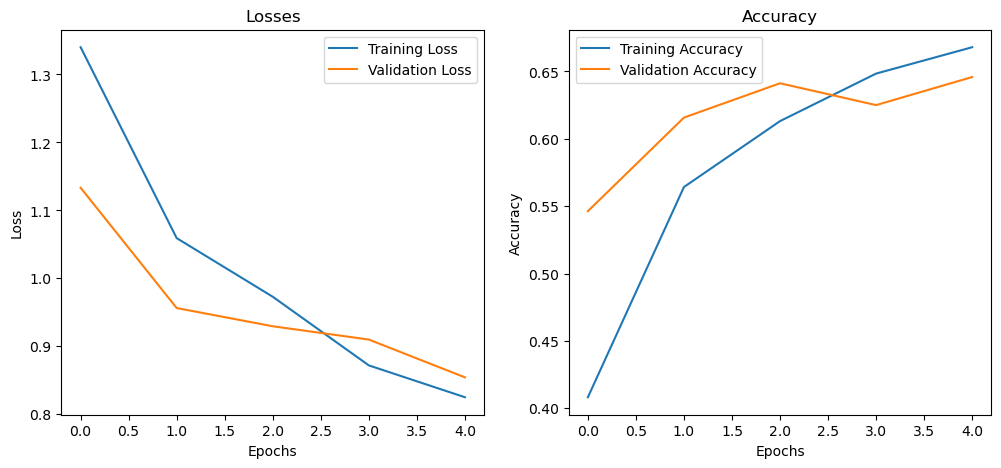

In [13]:
# グラフを保存するディレクトリを作成
output_dir = '../results'
os.makedirs(output_dir, exist_ok=True)

# タイムスタンプを生成
timestamp = datetime.now().strftime('%Y-%m-%d_%H-%M-%S')

# LossとAccuracyのデータをCSVファイルに保存
csv_filename = os.path.join(output_dir, f'results_{timestamp}.csv')
with open(csv_filename, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Training Loss', 'Validation Loss', 'Training Accuracy', 'Validation Accuracy'])
    
    for epoch in range(len(train_losses)):
        writer.writerow([epoch+1, train_losses[epoch], val_losses[epoch], train_accuracies[epoch], val_accuracies[epoch]])


# Lossのグラフを保存
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title(f'Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracyのグラフを保存
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.title(f'Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# 画像を保存
plt.savefig(os.path.join(output_dir, f'plot_{timestamp}.png'))

# 画像を表示
plt.show()
